## Compute forecast metrics using item-level backtests

<b>DC Bikeshare Rentals data</b>

Our goal is to predict the number of DC Bikeshare rentals in the next 24 hours for each of 467 rental locations.  To do this, we used Amazon Forecast to create forecasts with 1 hour frequency and 1 week forecast horizon.   
<ul>
    <li>See <a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/">blog post for screens how the forecast was created.</a></li>
    <li>Original data source: <a href="https://www.capitalbikeshare.com/system-data"> https://www.capitalbikeshare.com/system-data</a> </li>
</ul>

This notebook picks up after the blog post Predictor has been trained.  In the overall Amazon Forecast workflow, <b>this notebook covers <i>the step "Inspect ML model" which comes between steps Train ML model and Host ML model</i>, see overview image below.</b>  For demo purposes, we will visualize the item-level accuracies and calculate a custom item-level MAPE error metric, since customers often ask for custom metrics separate from standard weighted quantile loss (wQL).
<br>

Amazon Forecast Notebooks are useful to see the overall Forecast API workflow, see for example:<br>
<li><a href="https://github.com/aws-samples/amazon-forecast-samples/blob/master/notebooks/advanced/Incorporating_Related_Time_Series_dataset_to_your_Predictor/Incorporating_Related_Time_Series_dataset_to_your_Predictor.ipynb", target="_blank">Creating Related Time Series notebook for a good overview of the non-Weather Forecast API steps.</a></li>

Once you've run through a notebook once or twice, you'll probably decide you don't want to call Forecast APIs anymore via notebook!  More efficient use of your time is to call APIs from automation.  When you're ready, take a look at our Solution that uses AWS Lambda Step Functions and Amazon Quicksight for visualization to integrate Amazon Forecast with upstream/downstream Data applications.
<ul>
    <li><a href="https://aws.amazon.com/solutions/implementations/improving-forecast-accuracy-with-machine-learning", target='_blank'>Amazon Forecast Automation Solution</a></li>
    </ul>



<img src="images/forecast_steps_overview.png" width="98%">

<br>


# Table of Contents for task "inspect ML model"
* Step 0: [Set up and install libraries](#setup)
* Step 1: [Export predictor backtests](#export)
* Step 2: [Assemble and read predictor backtest files](#read)
* Step 3: [Visualize backtest window accuracy](#visualize)
* Step 4: [Calculate custom MAPE](#mape)


# Step 0:  Set up  <a class="anchor" id="setup"></a>
Import and install Python and aws libraries


In [9]:
import sys
import os
import shutil

import pandas as pd
print('pandas: {}'.format(pd.__version__))
# display all columns wide
pd.set_option('display.max_columns', None)
# display all rows long
pd.set_option('display.max_rows', None)
# display horizontal scrollbar for wide columns
pd.set_option('display.width', 5000)
pd.set_option('display.max_colwidth', 5000)
#turn off scientific notation
pd.set_option('display.float_format', lambda x: '%.5f' % x)

import numpy as np
print('numpy: {}'.format(np.__version__))
import matplotlib.pyplot as plt
%matplotlib inline 


# get region from boto3
import boto3
REGION = boto3.Session().region_name

# importing forecast notebook utility from notebooks/common directory
sys.path.insert( 0, os.path.abspath("./common") )
import util

pandas: 1.1.5
numpy: 1.19.5


In [10]:
#########
# Function to concat .part files in predictor backtest file export folder
#########

def read_backtest_predictions(BUCKET_NAME, s3_path, local_write_path="backtest_exports", backtest_date=None):
    """Read predictor backtest predictions export files
       Inputs: 
           BUCKET_NAME = S3 bucket name
           s3_path = S3 path to Predictor.part files
                         , everything after "s3://BUCKET_NAME/" in S3 URI path to your .part files
       Return: Pandas dataframe with all .part files concatenated row-wise
    """
    # set s3 path
    s3 = boto3.resource('s3')
    s3_bucket = boto3.resource('s3').Bucket(BUCKET_NAME)
    s3_depth = s3_path.split("/")
    s3_depth = len(s3_depth) - 1
    
    # set local path
#     local_write_path = "backtest_exports"
    if (os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        shutil.rmtree(local_write_path)
    if not(os.path.exists(local_write_path) and os.path.isdir(local_write_path)):
        os.makedirs(local_write_path)
    
    # concat part files
    part_filename = ""
    part_files = list(s3_bucket.objects.filter(Prefix=s3_path))
    print(f"Number .part files found: {len(part_files)}")
    for file in part_files:
        # There will be a collection of CSVs if the forecast is large, modify this to go get them all
        if "csv" in file.key:
            part_filename = file.key.split('/')[s3_depth]
            window_object = s3.Object(BUCKET_NAME, file.key)
            file_size = window_object.content_length
            if file_size > 0:
                s3.Bucket(BUCKET_NAME).download_file(file.key, local_write_path+"/"+part_filename)
        
    # Read from local dir and combine all the part files
    temp_dfs = []
    for entry in os.listdir(local_write_path):
        if os.path.isfile(os.path.join(local_write_path, entry)):
            df = pd.read_csv(os.path.join(local_write_path, entry), index_col=None, header=0)
            temp_dfs.append(df)

    # Return assembled .part files as pandas Dataframe
    fcst_df = pd.concat(temp_dfs, axis=0, ignore_index=True, sort=False)
    from datetime import datetime
    if backtest_date:
        fcst_df = fcst_df[fcst_df['backtestwindow_start_time']==backtest_date+"T00:00:00"]
    
    return fcst_df





###########
# Functions to calculate metrics
###########

def truncate_negatives_to_zero(the_df, target_value_col, quantile_cols):
    """In case you are expecting positive numbers for actuals and predictions,
       round negative values up to zero.
       
       Be careful that this is acceptable treatment of negatives for your use case.
    """
    
    df = the_df.copy()
    
    for q in quantile_cols:
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

        # replace
        df[q] = df[q].mask(df[q] < 0, 0)

        # check you did the right thing
        num_neg_predictions = df[q].lt(0).sum()
        print(f"Num negative {q} predictors: {num_neg_predictions}")

    # truncate negative actuals
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")

    # replace
    df[target_value_col] = df[target_value_col].mask(df[target_value_col] < 0, 0)

    # check you did the right thing
    num_neg_actuals = df[target_value_col].lt(0).sum()
    print(f"Num negative actuals: {num_neg_actuals}")
    
    return df

       
def calc_mape(target, forecast):
    """Calculates custom mape for a specific quantile and window with formula:
            sum(| |predicted| - |actual| | / |actual|)
       Input: single numbers for target and forecast
       Output: mape = floating point number
    """
    denominator = np.abs(target)
    flag = denominator <= 1e-8

    mape = np.mean(
        (np.abs( np.abs(target) - np.abs(forecast)) * (1.0 - flag)) / (denominator + flag)
    )
    return mape



In order to run Amazon Forecast, you'll need an AWS account.  
<b>Make sure you can log in to: https://console.aws.amazon.com/.  </b>  Then read each cell carefully and execute the cells in this notebook.
<br>

<b>Configure the S3 bucket name and region name for this lesson.</b>

- If you don't have an S3 bucket, create it first on S3.
- Although we have set the region to us-west-2 as a default value below, you can choose any of the regions that the service is available in.

In [3]:
bucket_name='sagemaker-us-west-2-230755935769'
predictor_arn='arn:aws:forecast:us-west-2:230755935769:predictor/m56_sku_prediction_8w_1_01FWTV1MQMTY63C5R7D0ZCM9FD'
region='us-west-2'
role_arn='arn:aws:iam::230755935769:role/ForecastNotebookRole'

In [11]:
%store -r bucket_name 
%store -r predictor_arn
# predictor_arn_deep_ar = "arn:aws:forecast:us-west-2:230755935769:predictor/loreal_sku_prediction_normal_4_CNNQR_RMSE_autopredictor_01FS208K3A8MEQSNDKCNVPMJAK"
%store -r region 
%store -r role_arn 

In [12]:
## Get user inputs for S3 bucket name and region

default_bucket = bucket_name
default_region = REGION

The next part of the setup process is to validate that your account can communicate with Amazon Forecast

In [13]:
# Connect API session
session = boto3.Session(region_name=REGION) 
forecast = session.client(service_name='forecast') 


The last part of the setup process is to create an AWS Role with Forecast and S3 permissions

In [14]:
# Create the role to provide to Amazon Forecast.

role_name = "ForecastNotebookRole"
print(f"Creating Role {role_name} ...")
role_arn = util.get_or_create_iam_role( role_name = role_name )


Creating Role ForecastNotebookRole ...
The role ForecastNotebookRole exists, ignore to create it
Done.


In [15]:
# check you did the right thing
forecast.list_predictors()

{'Predictors': [{'PredictorArn': 'arn:aws:forecast:us-west-2:230755935769:predictor/m5_sku_prediction_8w_4_01FX1DRWYXWPYQKX8A7MYN97F5',
   'PredictorName': 'm5_sku_prediction_8w_4',
   'DatasetGroupArn': 'arn:aws:forecast:us-west-2:230755935769:dataset-group/m5_sku_prediction_8w_4',
   'IsAutoPredictor': True,
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2022, 3, 1, 0, 23, 38, 241000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2022, 3, 1, 2, 36, 1, 303000, tzinfo=tzlocal())},
  {'PredictorArn': 'arn:aws:forecast:us-west-2:230755935769:predictor/nullable_predictor',
   'PredictorName': 'nullable_predictor',
   'DatasetGroupArn': 'arn:aws:forecast:us-west-2:230755935769:dataset-group/m5_sku_prediction_8w_3',
   'IsAutoPredictor': False,
   'Status': 'ACTIVE',
   'CreationTime': datetime.datetime(2022, 2, 28, 12, 18, 43, 719000, tzinfo=tzlocal()),
   'LastModificationTime': datetime.datetime(2022, 2, 28, 14, 9, 52, 69000, tzinfo=tzlocal())},
  {'Predict

# Step 1: Export predictor backtests <a class="anchor" id="export"></a>

After creating the predictors, we can export the Backtest Predictions to evaluate the performance of the algorithm, using custom item-level metrics if desired. "Backtesting" is a cross-validation technique for time series that uses multiple train/test splits that keep time order of the data. Using multiple train-test splits (i.e. more than 1 backtest window) will result in more models being trained, and in turn, a more robust estimate how the model (chosen algorithm and hyperameters) will perform on unseen data. 

<img src="images/backtest.png" width="80%" ></img>

<li><a href="https://docs.aws.amazon.com/forecast/latest/dg/metrics.html#backtesting", target='_blank'> More details about backtesting on the Amazon Forecast documentation page.</a></li>

In the next cell, we use your Predictor arn and export backtest files to your S3 bucket.  <b>To find your predictor ARN, navigate in the Amazon Forecast UI to your Predictor page. </b>
<img src="images/predictorARN.png" width="70%" ></img>
<br>

In [16]:
export_name = predictor_arn.split('/')[-1]
export_name

'm5_sku_prediction_8w_4_01FX1DRWYXWPYQKX8A7MYN97F5'

In [17]:
# Decide automatically where to save exported files


default_export_path = \
    f's3://{default_bucket}/backtest_exports/{export_name}/'
print(f"exporting to: {default_export_path}")
export_path = default_export_path

exporting to: s3://sagemaker-us-west-2-230755935769/backtest_exports/m5_sku_prediction_8w_4_01FX1DRWYXWPYQKX8A7MYN97F5/


<br>
In the next few cells, we ask Amazon Forecast to export the Predictor backtest window forecasts via API.  The same could be done by <li><a href="https://aws.amazon.com/blogs/machine-learning/measuring-forecast-model-accuracy-to-optimize-your-business-objectives-with-amazon-forecast/">clicking the "Export backtest results" button on the Predictor page, as shown in the blog.</a></li>
<br>
<br>

In [18]:

## Call CreatePredictorBacktestExportJob using predictor Arn and S3 export path

backtestExportJobName = f'{export_name[0:59]}_job'
backtest_export_job_response =forecast.create_predictor_backtest_export_job(PredictorBacktestExportJobName=backtestExportJobName,
                                                          PredictorArn=predictor_arn,
                                                          Destination= {
                                                              "S3Config" : {
                                                                 "Path":export_path,
                                                                 "RoleArn": role_arn
                                                              } 
                                                          })

In [19]:

# check for HTTPStatusCode 200
backtest_export_job_arn = backtest_export_job_response['PredictorBacktestExportJobArn']
backtest_export_job_response

{'PredictorBacktestExportJobArn': 'arn:aws:forecast:us-west-2:230755935769:predictor-backtest-export-job/m5_sku_prediction_8w_4/m5_sku_prediction_8w_4_01FX1DRWYXWPYQKX8A7MYN97F5_job',
 'ResponseMetadata': {'RequestId': 'c82249df-c62f-4bf5-9176-036ba95fa075',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'content-type': 'application/x-amz-json-1.1',
   'date': 'Tue, 01 Mar 2022 06:48:10 GMT',
   'x-amzn-requestid': 'c82249df-c62f-4bf5-9176-036ba95fa075',
   'content-length': '182',
   'connection': 'keep-alive'},
  'RetryAttempts': 0}}

In [20]:

## CHECK STATUS OF YOUR EXPORT JOB - BACKTEST FORECASTS


status = util.wait(lambda: forecast.describe_predictor_backtest_export_job(PredictorBacktestExportJobArn=
                backtest_export_job_arn))

# Wait until you see "ACTIVE" below...
# This will take a while, go get a cup of tea now. 

CREATE_IN_PROGRESS .................................
ACTIVE 


<br>
The API steps you did above, could equivalently be done in the UI by clicking the "Export backtest results" button on the Predictor page.  You'll see export job details on the screen.

<img src="images/export_backtest_results.png" width="80%" ></img>

# Step 2: Assemble and read predictor backtest files <a class="anchor" id="read"></a>

After Forecast Predictor Backtest Export step finishes, you will have a number of .part files within 2 separate folders.  The cell below concatenates all the .part files per folder into a single .csv file which can be saved to an S3 location of your choice. <br>

The folder structure for "Item-level standard accuracy metrics" and "Item-level forecasted values" folders will look like this on your S3 bucket:

<img src="images/export_backtest_folders.png" width="40%" ></img>
<br>

### Assemble and read Accuracy metrics file

In [21]:
# path to files is everything after BUCKET_NAME/, it should end in "/"
# s3_path_to_files = "s3://sagemaker-us-west-2-230755935769/backtest_exports/m56_sku_prediction_8w_1_01FWTV1MQMTY63C5R7D0ZCM9FD"
s3_path_to_files = export_path.split(default_bucket)[1][1:]
s3_path_to_files = s3_path_to_files + "accuracy-metrics-values/"

print(f"path to files: {s3_path_to_files}")

path to files: backtest_exports/m5_sku_prediction_8w_4_01FX1DRWYXWPYQKX8A7MYN97F5/accuracy-metrics-values/


In [22]:

## READ THE ACCURACIES FILE


accuracy_outcomes = [f'backtest_exports/{export_name}/accuracy-metrics-values/']
algo_names = [export_name]
accuracy_dfs = []



def postprocess(accuracy_df):
    accuracy_df = accuracy_df.loc[(accuracy_df.backtestwindow_start_time != "backtestwindow_start_time"), :].copy()
    
    accuracy_df.item_id = accuracy_df.item_id.astype(str)
    
    accuracy_df['backtestwindow_start_time'] = pd.to_datetime(accuracy_df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    accuracy_df['backtestwindow_end_time'] = pd.to_datetime(accuracy_df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    # convert UTC timestamp to timezone unaware
    accuracy_df['backtestwindow_start_time'] = accuracy_df.backtestwindow_start_time.dt.tz_localize(None)
    accuracy_df['backtestwindow_end_time'] = accuracy_df.backtestwindow_end_time.dt.tz_localize(None)
    for q in accuracy_df.iloc[:, -4:].columns:
        accuracy_df[q] = pd.to_numeric(accuracy_df[q], errors='coerce')

    return accuracy_df

backtest_offset=None

for i in range(0, len(accuracy_outcomes)):
    accuracy_df = read_backtest_predictions(default_bucket, accuracy_outcomes[i], algo_names[i], backtest_offset)
    accuracy_df =  postprocess(accuracy_df)
    accuracy_df = accuracy_df[['item_id', 'store_id','state_id', "backtestwindow_start_time", "RMSE", "MAPE"]]
    accuracy_df.drop_duplicates(inplace=True)
    accuracy_df = accuracy_df.rename(columns={'RMSE':algo_names[i]+"_RMSE"})
    accuracy_df = accuracy_df.rename(columns={'MAPE':algo_names[i]+"_MAPE"})
    accuracy_dfs.append(accuracy_df)


result = accuracy_dfs[0]    

for i in range(1, len(accuracy_dfs)):
    result = result.merge(accuracy_dfs[i], on=['item_id','store_id','state_id',"backtestwindow_start_time", "backtestwindow_end_time"])
    


Number .part files found: 26


In [47]:
result.sort_values(by=[f'{export_name}_RMSE'], ascending=False).head(30).tail(10)

,item_id,store_id,state_id,backtestwindow_start_time,m5_sku_prediction_8w_4_01FX1DRWYXWPYQKX8A7MYN97F5_RMSE,m5_sku_prediction_8w_4_01FX1DRWYXWPYQKX8A7MYN97F5_MAPE
10712,FOODS_3_318,WI_3,WI,2016-03-06,114.13134,0.62940
598,FOODS_3_086,TX_1,TX,2016-03-06,113.13468,0.41099
20731,FOODS_2_013,WI_2,WI,2016-03-06,108.40227,0.34188
8018,FOODS_3_090,WI_3,WI,2016-03-06,108.17024,0.17652
1297,FOODS_3_120,WI_3,WI,2016-03-06,106.20976,0.69039
6121,FOODS_3_752,WI_2,WI,2016-03-06,105.80778,3.04678
25467,FOODS_3_090,CA_2,CA,2016-03-06,104.30790,0.23589
5331,FOODS_3_587,WI_2,WI,2016-03-06,104.10942,0.60260
1691,FOODS_3_635,CA_3,CA,2016-03-06,103.50508,0.12380
18601,FOODS_3_587,TX_3,TX,2016-03-06,103.15191,0.58597


In [46]:
result.sort_values(by=[f'{export_name}_RMSE'], ascending=False).head(30).tail(10)[['item_id','store_id']]

,item_id,store_id
10712,FOODS_3_318,WI_3
598,FOODS_3_086,TX_1
20731,FOODS_2_013,WI_2
8018,FOODS_3_090,WI_3
1297,FOODS_3_120,WI_3
6121,FOODS_3_752,WI_2
25467,FOODS_3_090,CA_2
5331,FOODS_3_587,WI_2
1691,FOODS_3_635,CA_3
18601,FOODS_3_587,TX_3


2016-04-24 2011-01-29


<AxesSubplot:xlabel='timestamp'>

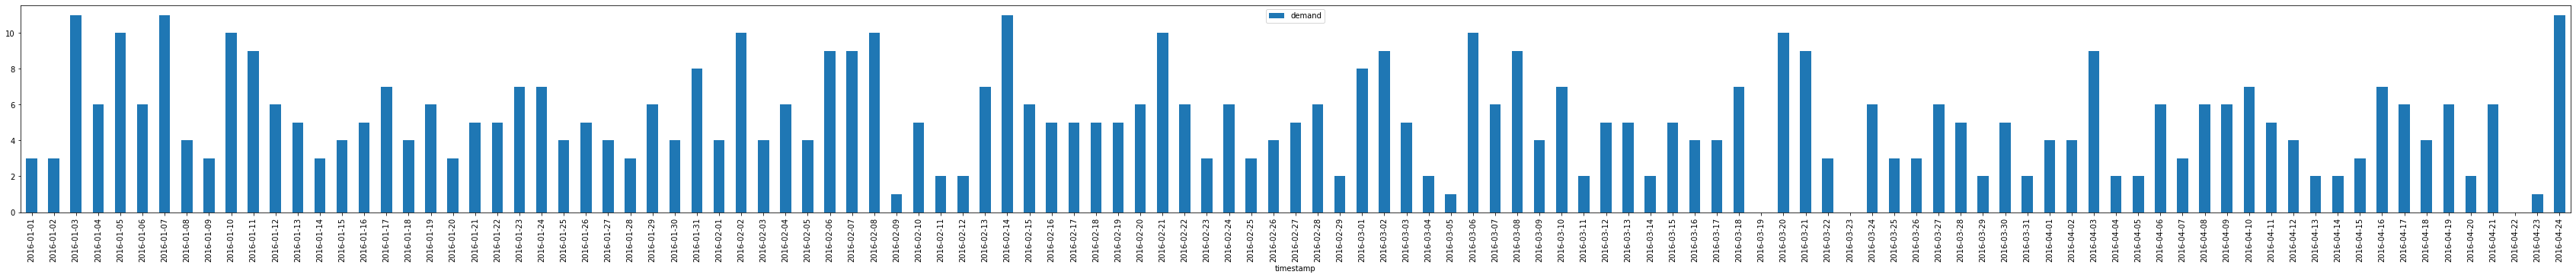

In [52]:
demand_df = pd.read_csv('./demands.csv')
print(demand_df.timestamp.max(), demand_df.timestamp.min())

# demand_df = demand_df[demand_df['timestamp']>='2021-10-01']
c_demand = demand_df[(demand_df['item_id']=="FOODS_2_349") & (demand_df['store_id']=="CA_3") & (demand_df['timestamp']>="2016-01-01")]
c_demand.groupby(['item_id','timestamp']).sum().reset_index().plot.bar(figsize=(60,5), x='timestamp', y='demand')

Typically, you would save the assembled accuracy file on your S3 bucket.  We've already saved it to data/bike_backtest_accuracies.csv.

### Assemble and read Forecasted values file

In [26]:
# path to files is everything after BUCKET_NAME/, it should end in "/"
s3_path_to_files = export_path.split(default_bucket)[1][1:]
s3_path_to_files = s3_path_to_files + "forecasted-values/"
print(f"path to files: {s3_path_to_files}")

path to files: backtest_exports/m5_sku_prediction_8w_4_01FX1DRWYXWPYQKX8A7MYN97F5/forecasted-values/


In [27]:
df = read_backtest_predictions(default_bucket, s3_path_to_files, backtest_date=None)

Number .part files found: 26


In [28]:
df.head()

,item_id,store_id,state_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p10,p50,p90
0,FOODS_3_382,CA_2,CA,2016-03-06T00:00:00Z,10.00000,2016-03-06T00:00:00,2016-04-24T00:00:00,1.58798,6.60053,11.82754
1,FOODS_3_382,CA_2,CA,2016-03-13T00:00:00Z,6.00000,2016-03-06T00:00:00,2016-04-24T00:00:00,-0.09540,5.59331,10.81034
2,FOODS_3_382,CA_2,CA,2016-03-20T00:00:00Z,6.00000,2016-03-06T00:00:00,2016-04-24T00:00:00,-0.86738,5.03837,10.49347
3,FOODS_3_382,CA_2,CA,2016-03-27T00:00:00Z,9.00000,2016-03-06T00:00:00,2016-04-24T00:00:00,-0.93064,4.46178,9.39836
4,FOODS_3_382,CA_2,CA,2016-04-03T00:00:00Z,7.00000,2016-03-06T00:00:00,2016-04-24T00:00:00,-0.76352,4.61050,10.54295


In [29]:

## READ THE FORECASTS FILE


item_id = "item_id"
target_value = "target_value"
timestamp = "timestamp"
location_id = "location"


def cast_quantile_cols(result_df):
    predictor_cols = ['item_id','store_id', 'state_id', 'timestamp', 'rest_no', 'backtestwindow_start_time', 'backtestwindow_end_time']
    exclude_cols = predictor_cols.copy()
    exclude_cols.append(target_value)

    # get quantile columns from forecast dataframe
    quantile_cols = [c for c in result_df.columns if c not in exclude_cols] 
    num_quantiles = len(quantile_cols)
    print(f"num quantiles: {num_quantiles}")
    for q in quantile_cols:
        result_df[q] = pd.to_numeric(result_df[q], errors='coerce')

    return result_df
    
def postprocess_predicted_value(result_df):
    result_df = result_df.loc[(result_df.backtestwindow_start_time != "backtestwindow_start_time"), :].copy()
    result_df.drop_duplicates(inplace=True)
    result_df.item_id = result_df.item_id.astype(str)
    result_df.target_value = pd.to_numeric(result_df.target_value, errors='coerce')
    df.timestamp = pd.to_datetime(df.timestamp
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    result_df['backtestwindow_start_time'] = pd.to_datetime(result_df['backtestwindow_start_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    result_df['backtestwindow_end_time'] = pd.to_datetime(result_df['backtestwindow_end_time']
                                                 , format="%Y-%m-%dT%H:%M:%S", errors='coerce')
    # convert UTC timestamp to timezone unaware
    result_df['backtestwindow_start_time'] = result_df.backtestwindow_start_time.dt.tz_localize(None)
    result_df['backtestwindow_end_time'] = result_df.backtestwindow_end_time.dt.tz_localize(None)
    result_df.timestamp = df.timestamp.dt.tz_localize(None)
    result_df.drop_duplicates(inplace=True)
    result_df = cast_quantile_cols(result_df)  
    return result_df

df = postprocess_predicted_value(df)

# check
num_items = len(df['item_id'].value_counts(normalize=True, dropna=False))
print(f"Num items: {num_items}")
print("Backtest Window Start Dates")


df.sample(5)

num quantiles: 3
Num items: 1437
Backtest Window Start Dates


,item_id,store_id,state_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p10,p50,p90
4765,FOODS_3_433,WI_1,WI,2016-04-10,7.00000,2016-03-06,2016-04-24,0.93133,6.84726,12.68657
23608,FOODS_2_050,CA_3,CA,2016-03-06,10.00000,2016-03-06,2016-04-24,2.16660,10.73568,18.87800
29017,FOODS_1_173,CA_3,CA,2016-03-13,54.00000,2016-03-06,2016-04-24,13.79221,49.73864,87.22416
33395,FOODS_3_467,CA_3,CA,2016-03-27,8.00000,2016-03-06,2016-04-24,1.43029,7.93898,15.33560
94101,FOODS_3_283,CA_2,CA,2016-04-10,24.00000,2016-03-06,2016-04-24,2.07173,14.09517,29.53504


In [30]:
df['store_id'].unique()

array(['CA_2', 'TX_3', 'CA_3', 'WI_2', 'TX_2', 'WI_1', 'TX_1', 'CA_1',
       'WI_3', 'CA_4'], dtype=object)

In [31]:
predictor_cols = ['item_id', 'timestamp', 'store_id', 'state_id', 'rest_no', 'backtestwindow_start_time', 'backtestwindow_end_time']
# exclude cols to automatically find quantiles
exclude_cols = predictor_cols.copy()
exclude_cols.append(target_value)

# get quantile columns from forecast dataframe
quantile_cols = [c for c in df.columns if c not in exclude_cols] 
num_quantiles = len(quantile_cols)
print(f"num quantiles: {num_quantiles}")
quantile_cols

num quantiles: 3


['p10', 'p50', 'p90']

Typically, you would save the assembled accuracy file on your S3 bucket.  We've already saved it to data/bike_backtest_forecasts.csv.

## Demo using the item-level forecast files  

The rest of this notebook will focus on how to use the item-level forecasts from the Predictor backtest windows. 
<br>

#### Before calling error calcs, truncate negative actuals and predictions to 0
If you are not expecting negatives, such as for counts

In [32]:

### Before calling error calcs, truncate negative actuals and predictions to 0

df_eligible = df.copy()
df_eligible = truncate_negatives_to_zero(df_eligible
                                         , target_value_col=target_value
                                         , quantile_cols=quantile_cols)


Num negative p10 predictors: 50709
Num negative p10 predictors: 0
Num negative p50 predictors: 1662
Num negative p50 predictors: 0
Num negative p90 predictors: 77
Num negative p90 predictors: 0
Num negative actuals: 0
Num negative actuals: 0


In [34]:
# Add window number for convenience
# windows = df_eligible.backtestwindow_start_time.value_counts().rename_axis('backtestwindow_start_time').reset_index(name='count')
# windows.sort_values('backtestwindow_start_time', inplace=True)
# windows.reset_index(inplace=True, drop=True)
# windows.drop('count', axis=1, inplace=True)
# windows['window'] = windows.index + 1

print(df_eligible.shape)
# df_eligible = df_eligible.merge(windows, how="left", on="backtestwindow_start_time")
# print(df_eligible.shape)
df_eligible.sample(5)

(114904, 10)


,item_id,store_id,state_id,timestamp,target_value,backtestwindow_start_time,backtestwindow_end_time,p10,p50,p90
105199,FOODS_3_164,TX_2,TX,2016-04-24,1.00000,2016-03-06,2016-04-24,0.00000,1.36576,4.75195
54051,FOODS_1_052,CA_2,CA,2016-03-27,6.00000,2016-03-06,2016-04-24,0.00000,1.83159,6.95433
35335,FOODS_1_127,CA_2,CA,2016-04-24,13.00000,2016-03-06,2016-04-24,0.00000,10.21182,21.35052
30656,FOODS_3_704,CA_2,CA,2016-03-06,21.00000,2016-03-06,2016-04-24,7.67275,19.41351,29.77242
45897,FOODS_2_167,WI_2,WI,2016-03-13,16.00000,2016-03-06,2016-04-24,1.87143,7.18135,12.32358


In [35]:
df_eligible.timestamp.unique()

array(['2016-03-06T00:00:00.000000000', '2016-03-13T00:00:00.000000000',
       '2016-03-20T00:00:00.000000000', '2016-03-27T00:00:00.000000000',
       '2016-04-03T00:00:00.000000000', '2016-04-10T00:00:00.000000000',
       '2016-04-17T00:00:00.000000000', '2016-04-24T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [36]:
df_eligible.dtypes

item_id                              object
store_id                             object
state_id                             object
timestamp                    datetime64[ns]
target_value                        float64
backtestwindow_start_time    datetime64[ns]
backtestwindow_end_time      datetime64[ns]
p10                                 float64
p50                                 float64
p90                                 float64
dtype: object

# Step 3: Visualize the Backtest Window forecasts  <a class="anchor" id="visualize"></a>

Below is 1 chart per item, for 5 random items in the "top-movers" item group.  Y-axis is Actuals and color-coded Forecasts at each quantile.  X-axis is time, starting from the first Backtest Window and ending with the last Backtest Window.
<br>

### plot AWS Prediction, Dr Martin Manual Prediction and Actual Value

In [55]:
# instead of random top-movers, choose some fixed examples
#worst 10 (RMSE)
# FOODS_2_360 	WI_2
# FOODS_3_362 	CA_3
# FOODS_3_120 	CA_3
# FOODS_3_007 	WI_2
# FOODS_3_382 	CA_3
# FOODS_3_234 	WI_2
# FOODS_3_233 	CA_3
# FOODS_3_681 	TX_1
# FOODS_3_120 	CA_1
# FOODS_3_282 	CA_3

# 20-30 
# FOODS_3_318 	WI_3
# FOODS_3_086 	TX_1
# FOODS_2_013 	WI_2
# FOODS_3_090 	WI_3
# FOODS_3_120 	WI_3
# FOODS_3_752 	WI_2
# FOODS_3_090 	CA_2
# FOODS_3_587 	WI_2
# FOODS_3_635 	CA_3
# FOODS_3_587 	TX_3



items = ['FOODS_2_360', 'FOODS_3_120', 'FOODS_3_681', 'FOODS_3_318', 'FOODS_3_635']
stores = ['WI_2', 'CA_3', 'TX_1', 'WI_3', 'CA_3']
plot_columns = ['item_id','store_id','timestamp', 'target_value']
plot_columns = plot_columns + quantile_cols
# assemble no_weather and weather values
plot_objs = []
# df_plot = pd.DataFrame()
# df_plot = df_eligible[df_eligible.item_id.isin(random_items)][plot_columns].copy()
for item, store in zip(items, stores): 
    c_plot = df_eligible[(df_eligible.item_id==item) & (df_eligible.store_id==store)][plot_columns].copy()
    plot_objs.append(c_plot)

df_plot = pd.concat(plot_objs,axis=0, ignore_index=True)

# rename "target_value" to "actual_value" for clearer viz
df_plot = df_plot.groupby([timestamp, 'store_id', item_id]).sum()
df_plot.reset_index(inplace=True)
df_plot.set_index(timestamp, inplace=True)
df_plot.head()

,store_id,item_id,target_value,p10,p50,p90
timestamp,,,,,,
2016-03-06,CA_3,FOODS_3_120,0.00000,190.65540,447.02132,631.47843
2016-03-06,CA_3,FOODS_3_635,211.00000,31.20327,171.98409,330.25848
2016-03-06,TX_1,FOODS_3_681,139.00000,20.63853,77.34684,139.92212
2016-03-06,WI_2,FOODS_2_360,509.00000,0.00000,48.63092,215.96101
2016-03-06,WI_3,FOODS_3_318,172.00000,0.00000,76.87817,288.28942


In [56]:
df_plot.columns

Index(['store_id', 'item_id', 'target_value', 'p10', 'p50', 'p90'], dtype='object')

['p10', 'p50', 'p90']
['p10', 'p50', 'p90']
['p10', 'p50', 'p90']
['p10', 'p50', 'p90']
['p10', 'p50', 'p90']


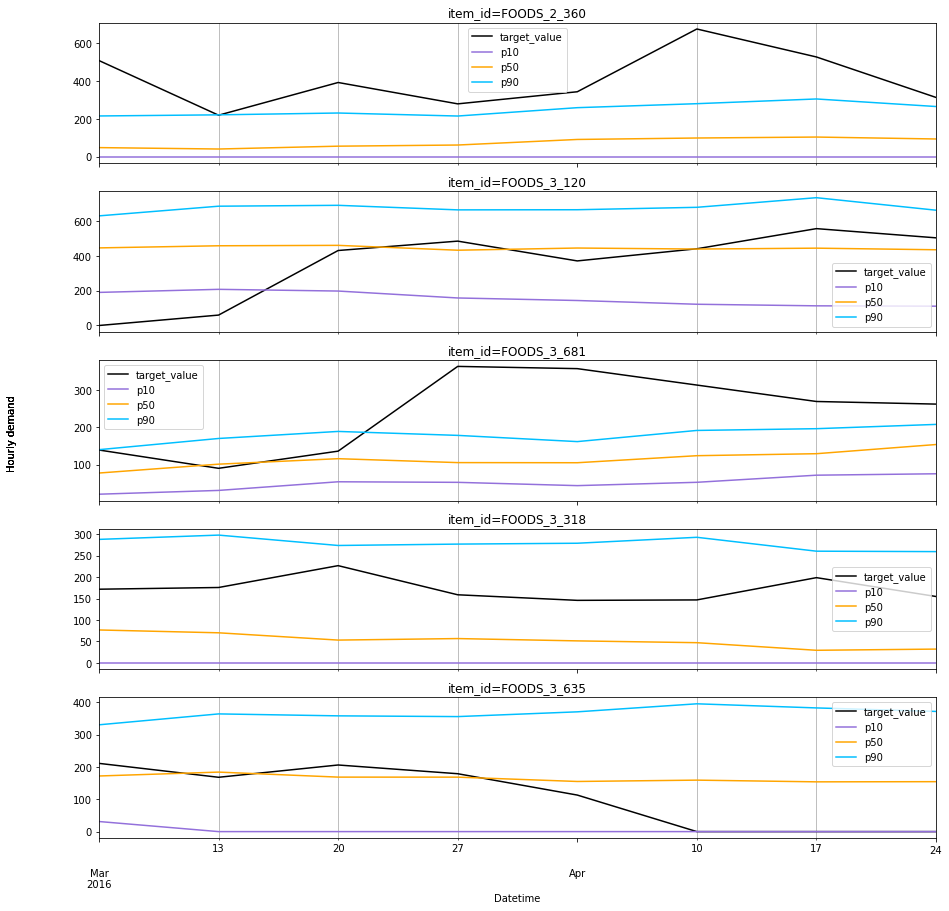

In [57]:
# Visualize items
fig, axs = plt.subplots(len(items), 1, figsize=(15, 15), sharex=True)

for i in range(len(items)):
    
    item = items[i]
    store = stores[i]
    zoomed = df_plot[(df_plot[item_id]==item) & (df_plot['store_id']==store)].copy()

    zoomed[['target_value']].plot(ax=axs[i], color='k')
    colors = ['mediumpurple', 'orange', 'deepskyblue']
    print(quantile_cols)
    for j in range(len(quantile_cols)):
        quantile = quantile_cols[j]
        zoomed[[quantile]].plot(ax=axs[i], color=colors[j])
            
    axs[i].set_title(f"item_id={item}")  
    # set common Y label 
    fig.text(0.04, 0.5, 'Hourly demand', va='center', rotation='vertical')
    
    # format the x ticks
    axs[i].set_xlabel("Datetime")   
        
    # format the grid
    axs[i].grid(False)
    axs[i].grid(which='minor', axis='x')

Above, peak hours for bicycle rental appear to be between 5-9am and 3-9pm.  For a real customer study, we really should select more data to verify the peak hours...
<br>

<AxesSubplot:xlabel='timestamp'>

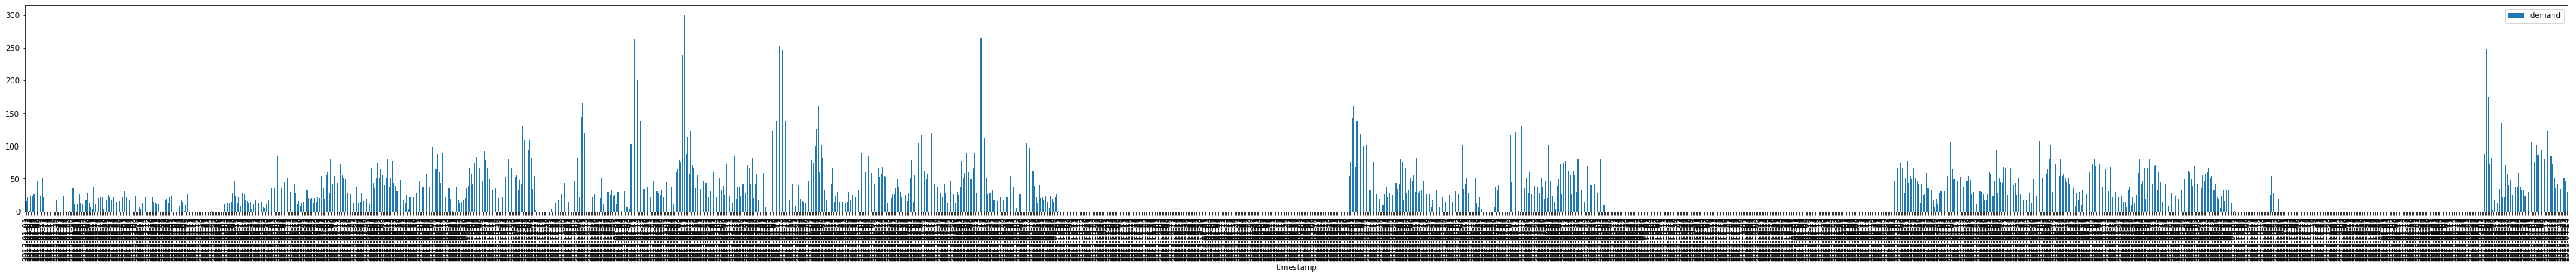

In [58]:
c_demand = demand_df[(demand_df['item_id']=="FOODS_2_360") & (demand_df['store_id']=="WI_2") & (demand_df['timestamp']>="2012-01-01")]
c_demand.groupby(['item_id','timestamp']).sum().reset_index().plot.bar(figsize=(60,5), x='timestamp', y='demand')